#Complexity Loss as a Biomarker for Alzheimer's Disease

## Installation des librairies


In [29]:
!pip install -q kagglehub pillow matplotlib scikit-learn seaborn


## Configuration Kaggle

In [30]:
from google.colab import files
import os
import json

!mkdir -p ~/.kaggle

kaggle_credentials = {
    "username": "zaitinesnawel",
    "key": "1420cf20f7cc132b17b484f588ddfe9f"
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

!chmod 600 /root/.kaggle/kaggle.json

print("Kaggle authentication configured!")

Kaggle authentication configured!


## Imports

In [31]:
import numpy as np
import gzip
import bz2
import lzma
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import kagglehub

plt.style.use('default')
sns.set_palette("husl")

## 1 - Mesure de complexité

In [32]:
def kolmogorov_complexity(data, method='gzip'):
    """Approximation K-complexity via compression"""
    if isinstance(data, np.ndarray):
        data = data.tobytes()

    original_size = len(data)

    if method == 'gzip':
        compressed = gzip.compress(data, compresslevel=9)
    elif method == 'bz2':
        compressed = bz2.compress(data, compresslevel=9)
    elif method == 'lzma':
        compressed = lzma.compress(data, preset=9)
    else:
        raise ValueError(f"Unknown method: {method}")

    compressed_size = len(compressed)
    return compressed_size / original_size


def conditional_complexity(image1, image2, method='gzip'):
    """Distance informationnelle entre deux images"""
    if isinstance(image1, np.ndarray):
        image1 = image1.tobytes()
    if isinstance(image2, np.ndarray):
        image2 = image2.tobytes()

    cx = len(gzip.compress(image1))
    cy = len(gzip.compress(image2))
    cxy = len(gzip.compress(image1 + image2))

    nid = (cxy - min(cx, cy)) / max(cx, cy)
    return nid


def regional_complexity_map(image, grid_size=8):
    """Carte de complexité régionale"""
    h, w = image.shape
    step_h = h // grid_size
    step_w = w // grid_size

    complexity_map = np.zeros((grid_size, grid_size))

    for i in range(grid_size):
        for j in range(grid_size):
            region = image[i*step_h:(i+1)*step_h, j*step_w:(j+1)*step_w]
            complexity_map[i, j] = kolmogorov_complexity(region)

    return complexity_map

In [33]:
def resize_image(image, scale):
    """Redimensionne une image par un facteur"""
    h, w = image.shape
    new_h, new_w = int(h * scale), int(w * scale)
    img_pil = Image.fromarray(image)
    img_resized = img_pil.resize((new_w, new_h), Image.LANCZOS)
    return np.array(img_resized)


def extract_patches(image, size=32):
    """Extrait des patches non-overlapping"""
    h, w = image.shape
    patches = []
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patches.append(image[i:i+size, j:j+size])
    return patches


def compress_ratio(data, method='gzip'):
    """Wrapper pour kolmogorov_complexity"""
    return kolmogorov_complexity(data, method)

## 2 - Chargement des donnés

In [34]:
def explore_dataset_structure(dataset_path):
    """Explore la structure du dataset"""
    dataset_path = Path(dataset_path)

    def print_tree(directory, prefix="", max_depth=3, current_depth=0):
        if current_depth > max_depth:
            return

        items = sorted(directory.iterdir())
        dirs = [item for item in items if item.is_dir()]
        files = [item for item in items if item.is_file()]

        for i, subdir in enumerate(dirs):
            is_last = (i == len(dirs) - 1) and len(files) == 0
            print(f"{prefix}{'└── ' if is_last else '├── '} {subdir.name}")

            img_count = len(list(subdir.glob('*.jpg'))) + len(list(subdir.glob('*.png')))
            if img_count > 0:
                print(f"{prefix}{'    ' if is_last else '│   '}    ({img_count} images)")

            new_prefix = prefix + ("    " if is_last else "│   ")
            print_tree(subdir, new_prefix, max_depth, current_depth + 1)

    print_tree(dataset_path)
    print()


def load_mri_dataset_from_kaggle():
    """Télécharge et charge le dataset"""
    path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")
    print(f" Dataset downloaded to: {path}\n")

    return load_mri_dataset_from_path(path)


def load_mri_dataset_from_path(dataset_path):
    """Charge le dataset depuis un path"""
    dataset_path = Path(dataset_path)
    explore_dataset_structure(dataset_path)

    category_keywords = {
        'no': ('No Impairment', 0),
        'very mild': ('Very Mild Impairment', 1),
        'mild': ('Mild Impairment', 2),
        'moderate': ('Moderate Impairment', 3)
    }

    label_names = ['No Impairment', 'Very Mild Impairment',
                   'Mild Impairment', 'Moderate Impairment']

    images = []
    labels = []


    def scan_directory(directory, depth=0):
        if depth > 5:
            return

        for item in directory.iterdir():
            if item.is_dir():
                folder_name_lower = item.name.lower()

                matched = False
                for keyword, (category_name, label) in category_keywords.items():
                    if keyword in folder_name_lower:
                        img_files = list(item.glob('*.jpg')) + list(item.glob('*.png'))

                        for img_path in img_files:
                            try:
                                img = Image.open(img_path).convert('L')
                                img = img.resize((128, 128))
                                images.append(np.array(img))
                                labels.append(label)
                            except Exception as e:
                                print(f" Error: {img_path.name}")

                        if len(img_files) > 0:
                            print(f"   {category_name}: {len(img_files)} images (from {item.name})")
                        matched = True
                        break

                if not matched:
                    scan_directory(item, depth + 1)

    scan_directory(dataset_path)

    if len(images) == 0:
        print("\n No images found!")
        return np.array([]), np.array([]), label_names

    return np.array(images), np.array(labels), label_names

## 3 - Extraction des features


In [35]:
def extract_rich_features(image):
    """Features enrichies - VERSION CORRIGÉE"""
    features = []

    # 1. Multi-scale compression
    for scale in [0.25, 0.5, 1.0]:
        resized = resize_image(image, scale)
        features.append(compress_ratio(resized, 'gzip'))

    # 2. Régions anatomiques approximatives
    h, w = image.shape
    hippocampus = image[int(h*0.5):int(h*0.8), int(w*0.3):int(w*0.7)]
    cortex = image[int(h*0.15):int(h*0.5), :]
    features.append(compress_ratio(hippocampus, 'gzip'))
    features.append(compress_ratio(cortex, 'gzip'))

    # 3. Variabilité locale
    patches = extract_patches(image, size=32)
    if len(patches) > 0:
        patch_complexities = [compress_ratio(p, 'gzip') for p in patches]
        features.append(np.std(patch_complexities))
        features.append(np.mean(patch_complexities))
    else:
        features.extend([0, 0])

    # 4. Complexité des gradients
    edges = sobel(image.astype(float))
    features.append(compress_ratio(edges.astype(np.uint8), 'gzip'))

    # 5. Multi-compressor ensemble
    features.append(compress_ratio(image, 'gzip'))
    features.append(compress_ratio(image, 'bz2'))
    features.append(compress_ratio(image, 'lzma'))

    return np.array(features)


def extract_complexity_features(images, verbose=True):
    """Extrait features pour tous les images"""
    features = []
    n = len(images)

    for idx, img in enumerate(images):
        if verbose and (idx + 1) % 100 == 0:
            print(f"   Processing: {idx+1}/{n}")
        features.append(extract_rich_features(img))

    return np.array(features)


## 4 - Classification MDL

In [36]:

def mdl_classifier(X_train, y_train, X_test, verbose=True):
    """Classifieur MDL basique"""
    classes = np.unique(y_train)
    prototypes = {}

    for c in classes:
        class_images = X_train[y_train == c]
        prototypes[c] = np.mean(class_images, axis=0).astype(np.uint8)
        print(f"   Class {c}: {len(class_images)} samples")

    predictions = []
    n = len(X_test)

    for idx, test_img in enumerate(X_test):
        if verbose and (idx + 1) % 50 == 0:
            print(f"   {idx+1}/{n}")

        min_complexity = float('inf')
        predicted_class = None

        for c, prototype in prototypes.items():
            complexity = conditional_complexity(test_img, prototype)

            if complexity < min_complexity:
                min_complexity = complexity
                predicted_class = c

        predictions.append(predicted_class)

    return np.array(predictions)


## 5 - Visualisation

In [37]:
def plot_complexity_evolution(images, labels, label_names):
    """Visualise l'évolution de la complexité"""
    complexities = []

    for idx, img in enumerate(images):
        if (idx + 1) % 100 == 0:
            print(f"   {idx+1}/{len(images)}")
        complexities.append(kolmogorov_complexity(img))

    complexities = np.array(complexities)

    for label, name in enumerate(label_names):
        mask = (labels == label)
        if np.sum(mask) > 0:
            mean_c = np.mean(complexities[mask])
            std_c = np.std(complexities[mask])
            print(f"  {name}: {mean_c:.4f} ± {std_c:.4f}")

    plt.figure(figsize=(12, 6))

    colors = ['green', 'yellow', 'orange', 'red']
    for label, name in enumerate(label_names):
        mask = (labels == label)
        if np.sum(mask) > 0:
            plt.scatter(np.full(np.sum(mask), label), complexities[mask],
                       alpha=0.6, label=name, color=colors[label], s=50)

    means = [np.mean(complexities[labels == l]) for l in range(len(label_names))]
    plt.plot(range(len(label_names)), means, 'k--', linewidth=2, label='Mean trend')

    plt.xlabel('Disease Stage', fontsize=12)
    plt.ylabel('Compression Ratio (↓ = more complex)', fontsize=12)
    plt.title('Complexity Loss Across Alzheimer\'s Stages\n(AIT Hypothesis Test)', fontsize=14)
    plt.xticks(range(len(label_names)), label_names, rotation=20, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualize_anomaly_detection(image, label, label_name):
    """Visualise les zones d'anomalie"""
    comp_map = regional_complexity_map(image, grid_size=16)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f'Original MRI\n{label_name}', fontsize=12)
    axes[0].axis('off')

    im = axes[1].imshow(comp_map, cmap='hot', interpolation='nearest')
    axes[1].set_title('Complexity Map\n(darker = simpler)', fontsize=12)
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    axes[1].axis('off')

    threshold = np.percentile(comp_map, 25)
    anomaly_mask = comp_map < threshold
    axes[2].imshow(image, cmap='gray')
    axes[2].imshow(anomaly_mask, cmap='Reds', alpha=0.4)
    axes[2].set_title('Low-Complexity Regions\n(Potential Atrophy)', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


def compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_mdl, label_names):
    """Compare MDL avec Random Forest"""
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_features, y_train)
    y_pred_rf = rf.predict(X_test_features)

    acc_mdl = accuracy_score(y_test, y_pred_mdl)
    acc_rf = accuracy_score(y_test, y_pred_rf)



    print(f"\n MDL Classifier (AIT-based):")
    print(f"   Accuracy: {acc_mdl:.2%}")
    print(classification_report(y_test, y_pred_mdl, target_names=label_names))

    print(f"\n Random Forest:")
    print(f"   Accuracy: {acc_rf:.2%}")
    print(classification_report(y_test, y_pred_rf, target_names=label_names))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    cm_mdl = confusion_matrix(y_test, y_pred_mdl)
    cm_rf = confusion_matrix(y_test, y_pred_rf)

    sns.heatmap(cm_mdl, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names, ax=axes[0])
    axes[0].set_title(f'MDL Classifier\nAccuracy: {acc_mdl:.2%}')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
                xticklabels=label_names, yticklabels=label_names, ax=axes[1])
    axes[1].set_title(f'Random Forest\nAccuracy: {acc_rf:.2%}')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

## 6 - Pipeline principale


[1/6] LOADING DATASET
Using Colab cache for faster access to the 'best-alzheimer-mri-dataset-99-accuracy' dataset.
 Dataset downloaded to: /kaggle/input/best-alzheimer-mri-dataset-99-accuracy

└── 📁 Combined Dataset
    ├── 📁 test
    │   ├── 📁 Mild Impairment
    │   │       (179 images)
    │   ├── 📁 Moderate Impairment
    │   │       (12 images)
    │   ├── 📁 No Impairment
    │   │       (640 images)
    │   └── 📁 Very Mild Impairment
    │           (448 images)
    └── 📁 train
        ├── 📁 Mild Impairment
        │       (2560 images)
        ├── 📁 Moderate Impairment
        │       (2560 images)
        ├── 📁 No Impairment
        │       (2560 images)
        └── 📁 Very Mild Impairment
                (2560 images)

   No Impairment: 640 images (from No Impairment)
   Very Mild Impairment: 448 images (from Very Mild Impairment)
   Moderate Impairment: 12 images (from Moderate Impairment)
   Mild Impairment: 179 images (from Mild Impairment)
   No Impairment: 2560 images (fr

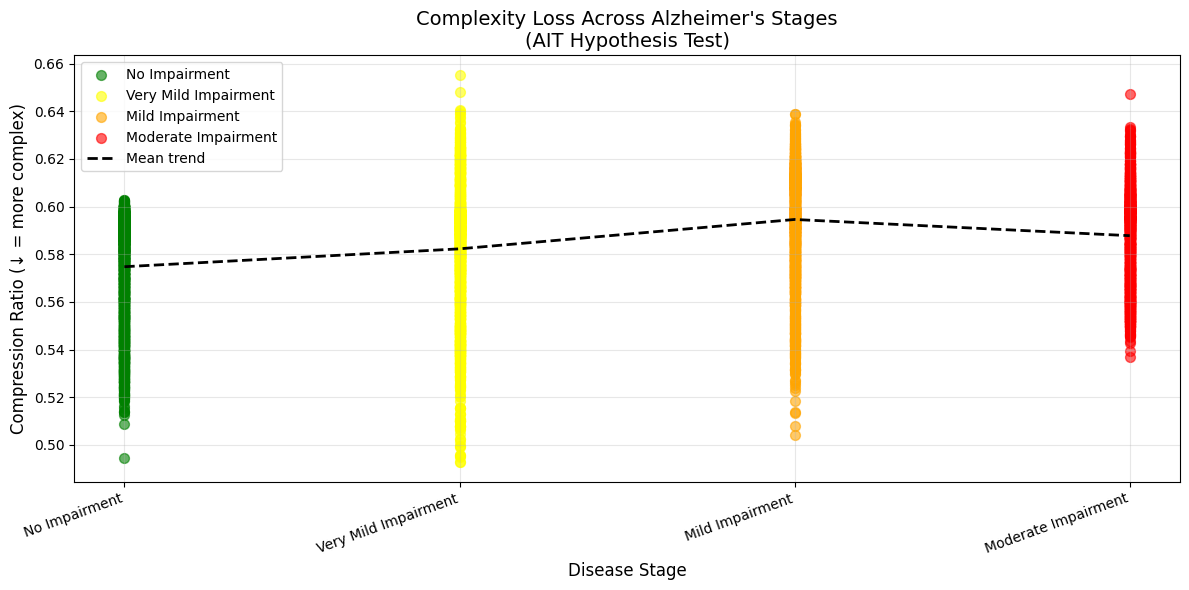


[4/6] EXTRACTING FEATURES
   Processing: 100/9215
   Processing: 200/9215
   Processing: 300/9215
   Processing: 400/9215
   Processing: 500/9215
   Processing: 600/9215
   Processing: 700/9215
   Processing: 800/9215
   Processing: 900/9215
   Processing: 1000/9215
   Processing: 1100/9215
   Processing: 1200/9215
   Processing: 1300/9215
   Processing: 1400/9215
   Processing: 1500/9215
   Processing: 1600/9215
   Processing: 1700/9215
   Processing: 1800/9215
   Processing: 1900/9215
   Processing: 2000/9215
   Processing: 2100/9215
   Processing: 2200/9215
   Processing: 2300/9215
   Processing: 2400/9215
   Processing: 2500/9215
   Processing: 2600/9215
   Processing: 2700/9215
   Processing: 2800/9215
   Processing: 2900/9215
   Processing: 3000/9215
   Processing: 3100/9215
   Processing: 3200/9215
   Processing: 3300/9215
   Processing: 3400/9215
   Processing: 3500/9215
   Processing: 3600/9215
   Processing: 3700/9215
   Processing: 3800/9215
   Processing: 3900/9215
   Proc

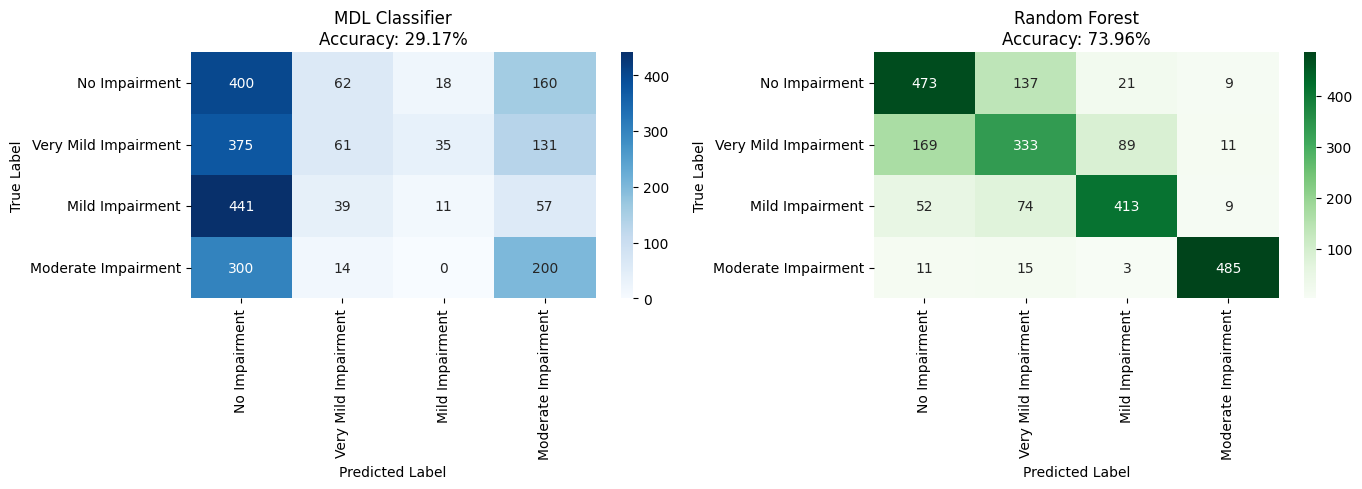


[BONUS] ANOMALY DETECTION

Visualizing: No Impairment


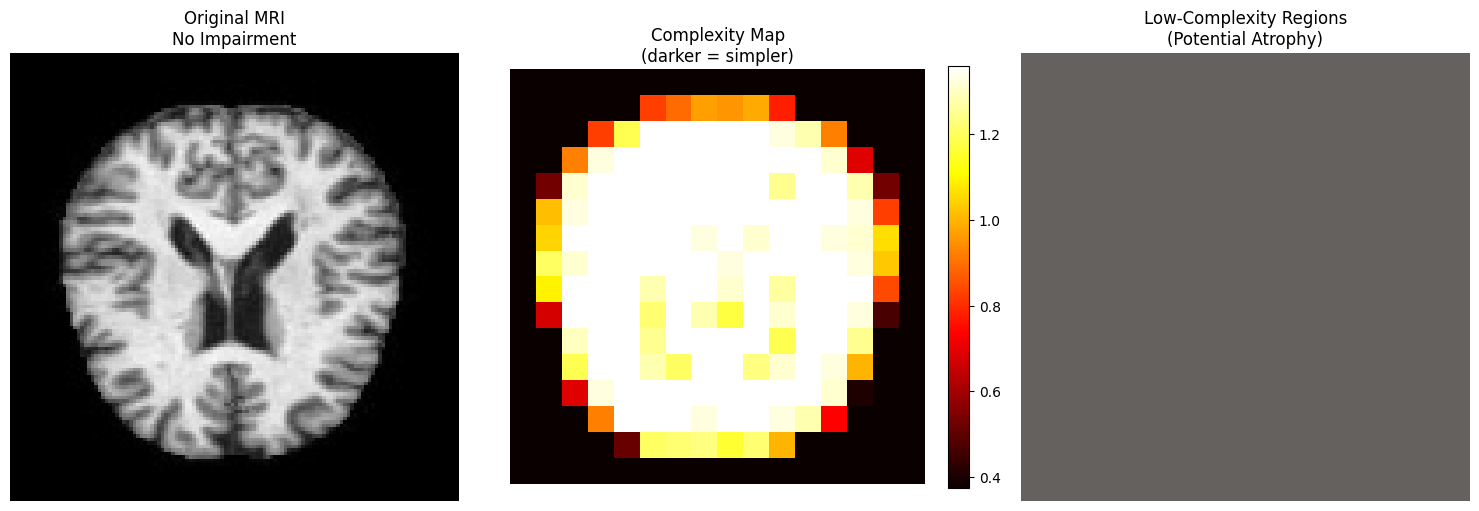


Visualizing: Very Mild Impairment


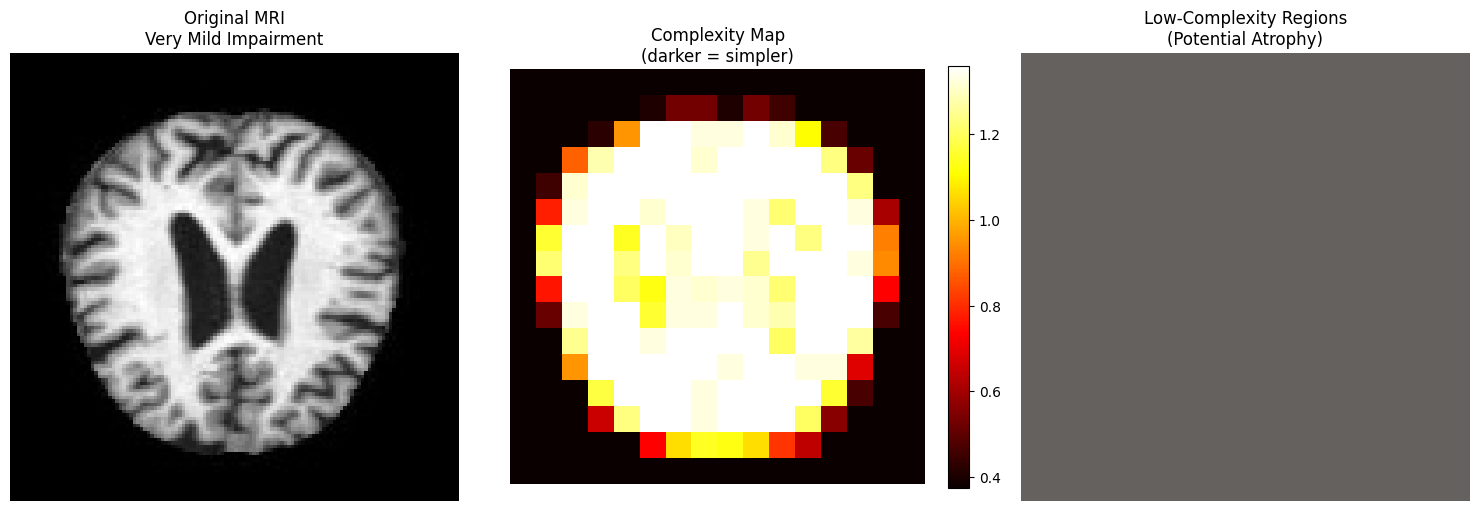


Visualizing: Mild Impairment


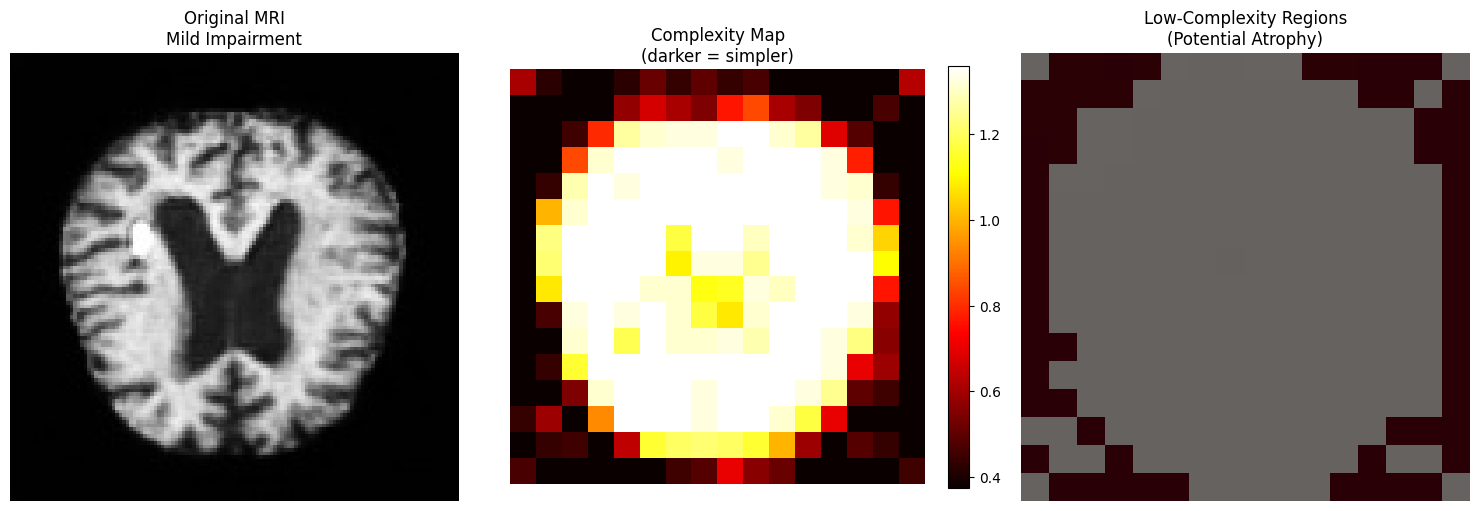


Visualizing: Moderate Impairment


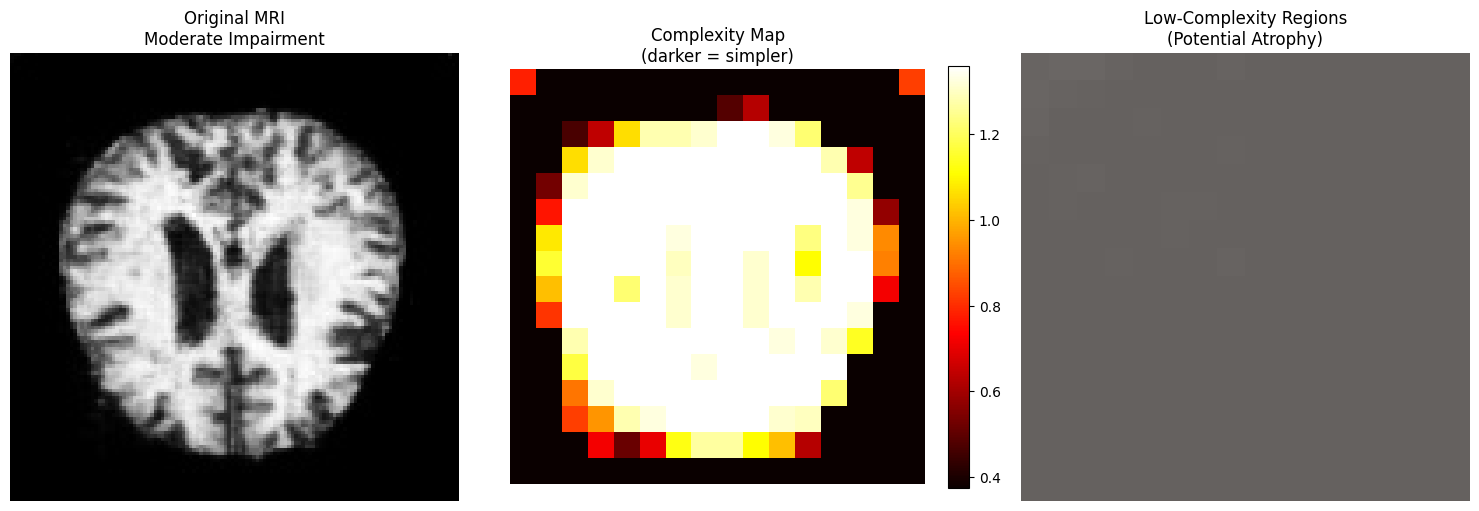

In [38]:
def main():

    # 1. Charger les données
    print("\n[1/6] LOADING DATASET")
    images, labels, label_names = load_mri_dataset_from_kaggle()
    print(f"\n Total images: {len(images)}")
    print(f" Image shape: {images[0].shape}")
    print(f" Classes: {label_names}")

    # 2. Split
    print("\n[2/6] SPLITTING DATA")
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f" Train: {len(X_train)} | Test: {len(X_test)}")

    # 3. Analyse de complexité
    print("\n[3/6] COMPLEXITY EVOLUTION ANALYSIS")
    plot_complexity_evolution(X_train, y_train, label_names)

    # 4. Extraction de features
    print("\n[4/6] EXTRACTING FEATURES")
    X_train_features = extract_complexity_features(X_train)
    X_test_features = extract_complexity_features(X_test)
    print(f" Feature dimension: {X_train_features.shape[1]}")

    # 5. Classification MDL
    print("\n[5/6] MDL CLASSIFICATION")
    y_pred_mdl = mdl_classifier(X_train, y_train, X_test)

    # 6. Comparaison
    print("\n[6/6] COMPARISON")
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_mdl, label_names)

    # Bonus: Anomalies
    print("\n[BONUS] ANOMALY DETECTION")
    for stage in range(len(label_names)):
        idx = np.where(y_test == stage)[0]
        if len(idx) > 0:
            print(f"\nVisualizing: {label_names[stage]}")
            visualize_anomaly_detection(X_test[idx[0]], stage, label_names[stage])




if __name__ == "__main__":
    main()